In [89]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# 1. class MyPCA

In [90]:
class MyPCA:
    def __init__(self, n_components=None):
        self.n_components = n_components

    def fit(self, X):
        # 1) Tâm dữ liệu
        self.mean_ = np.mean(X, axis=0)
        Xc = X - self.mean_
        # 2) Ma trận hiệp phương sai
        C = np.cov(Xc, rowvar=False)
        # 3) Tính trị riêng
        eigvals, eigvecs = np.linalg.eigh(C)
        # 4) Sắp xếp giảm dần
        idx = np.argsort(eigvals)[::-1]
        eigvals = eigvals[idx]
        eigvecs = eigvecs[:, idx]
        # 5) Chọn số thành phần
        if self.n_components is not None:
            eigvals = eigvals[:self.n_components]
            eigvecs = eigvecs[:, :self.n_components]
        # 6) Lưu kết quả
        self.components_ = eigvecs.T
        self.explained_variance_ = eigvals
        total_var = np.sum(eigvals)
        self.explained_variance_ratio_ = eigvals / total_var
        self.cumulative_explained_variance_ = np.cumsum(self.explained_variance_ratio_)
        return self

    def transform(self, X):
        Xc = X - self.mean_
        return Xc.dot(self.components_.T)

    def fit_transform(self, X):
        return self.fit(X).transform(X)

# 2. Phân cụm KMeans 

In [91]:
def kmeans(X, k, max_iters, tol, n_init, init_method):
    # Get dimensions
    n, d = X.shape
    best_centers = None
    best_labels = None
    best_inertia = float('inf')
    
    for init_attempt in range(n_init):
        # Initialize random generator with seed
        rng = np.random.default_rng(seed=42+init_attempt)
        
        # Initialize centers array
        centers = np.zeros((k, d))  # Add this line to initialize centers
        
        if init_method == 'kmeans++':
            # Choose first center randomly
            centers[0] = X[rng.choice(n)].copy()
            
            # Choose remaining centers
            for i in range(1, k):
                # Compute distances to closest centers
                min_dists = np.min([np.sum((X - centers[j])**2, axis=1) for j in range(i)], axis=0)
                
                # Fix NaN and zero-sum issues
                min_dists = np.nan_to_num(min_dists, nan=0.0)
                
                # Handle the case where all distances are zero
                if np.sum(min_dists) <= 1e-10:
                    centers[i] = X[rng.choice(n)].copy()
                else:
                    # Calculate probabilities proportional to squared distance
                    probs = min_dists / np.sum(min_dists)
                    # Ensure no remaining NaNs in probs
                    probs = np.nan_to_num(probs, nan=0.0)
                    # Normalize again
                    if np.sum(probs) > 0:
                        probs = probs / np.sum(probs)
                    else:
                        probs = np.ones(n) / n
                        
                    next_idx = rng.choice(range(n), p=probs)
                    centers[i] = X[next_idx].copy()
        else:
            # Random initialization
            indices = rng.choice(n, size=k, replace=False)
            centers = X[indices].copy()
            
        labels = np.zeros(n, dtype=int)

        for it in range(max_iters):
            # 2) Gán nhãn
            dist = np.linalg.norm(X[:, None, :] - centers[None, :, :], axis=2)
            new_labels = np.argmin(dist, axis=1)

            # Kiểm tra xem có cluster trống không
            unique_labels = np.unique(new_labels)
            if len(unique_labels) < k:
                # Khởi tạo lại các center cho cluster trống
                for j in range(k):
                    if j not in unique_labels:
                        # Gán cho cluster trống một điểm ngẫu nhiên xa các centers hiện tại
                        farthest_idx = np.argmax(np.min(dist, axis=1))
                        centers[j] = X[farthest_idx].copy()
                continue

            # 3) Cập nhật centers
            new_centers = np.zeros_like(centers)
            for j in range(k):
                pts = X[new_labels == j]
                new_centers[j] = pts.mean(axis=0) if len(pts) > 0 else centers[j]

            # Kiểm tra hội tụ
            shift = np.linalg.norm(new_centers - centers)
            centers = new_centers
            labels = new_labels
            if shift < tol:
                break

        # Tính inertia
        inertia = 0
        for j in range(k):
            cluster_points = X[labels == j]
            if len(cluster_points) > 0:
                inertia += np.sum(np.linalg.norm(cluster_points - centers[j], axis=1)**2)

        # Cập nhật kết quả tốt nhất
        if inertia < best_inertia:
            best_inertia = inertia
            best_labels = labels
            best_centers = centers

    return best_labels, best_centers, best_inertia

# 3. Chuẩn bị dữ liệu

In [92]:
df = pd.read_csv('../data/ABIDE2.csv')

In [93]:
print(f"Kích thước dataset: {df.shape}")
print(f"Số lượng mỗi nhóm:")
print(df['group'].value_counts())

Kích thước dataset: (1004, 1445)
Số lượng mỗi nhóm:
group
Normal    541
Cancer    463
Name: count, dtype: int64


In [94]:
# Giả sử các cột ['site','subject','group'] không dùng cho clustering
X_abide = df.drop(columns=['site','subject','group']).values
y_abide = df['group'].values 

# Chuyển nhãn thành số (0: Normal, 1: Cancer)
y_numeric = np.where(y_abide == 'Cancer', 1, 0)

# Chuẩn hóa
X_abide_std = (X_abide - X_abide.mean(axis=0)) / X_abide.std(axis=0)

# 4. Tìm các tham số tối ưu


In [95]:
pca_full = MyPCA()
pca_full.fit(X_abide_std)

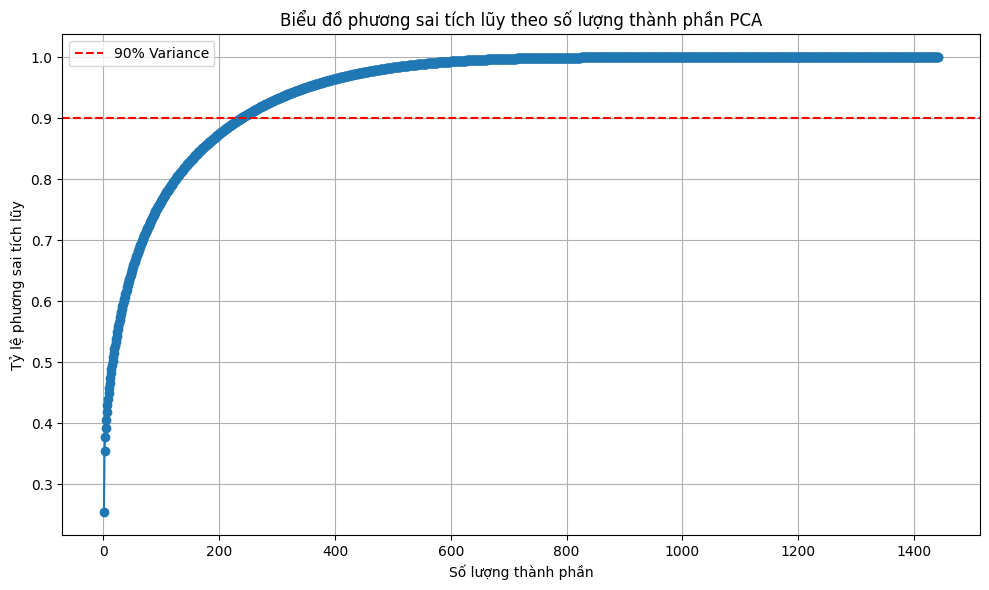

In [96]:
# Vẽ biểu đồ phương sai tích lũy
plt.figure(figsize=(10, 6))
plt.plot(np.arange(1, len(pca_full.explained_variance_ratio_) + 1), 
         pca_full.cumulative_explained_variance_, 'o-', markersize=6)
plt.axhline(y=0.9, color='r', linestyle='--', label='90% Variance')
plt.grid(True)
plt.xlabel('Số lượng thành phần')
plt.ylabel('Tỷ lệ phương sai tích lũy')
plt.title('Biểu đồ phương sai tích lũy theo số lượng thành phần PCA')
plt.legend()
plt.tight_layout()

In [97]:
# Tìm số lượng PC cần thiết cho các ngưỡng variance khác nhau
variance_thresholds = [0.70, 0.80, 0.85, 0.90, 0.95]
n_components_list = []

for threshold in variance_thresholds:
    n_comp = np.where(pca_full.cumulative_explained_variance_ >= threshold)[0][0] + 1
    n_components_list.append(n_comp)
    print(f"Số lượng PC để giữ {threshold*100:.0f}% variance: {n_comp}")

Số lượng PC để giữ 70% variance: 68
Số lượng PC để giữ 80% variance: 125
Số lượng PC để giữ 85% variance: 171
Số lượng PC để giữ 90% variance: 238
Số lượng PC để giữ 95% variance: 349


Components: 10, Init: random
  Silhouette: 0.287
  Accuracy: 0.540
  Precision: 0.501
  Recall: 0.408
  F1: 0.450
Components: 10, Init: kmeans++
  Silhouette: 0.287
  Accuracy: 0.540
  Precision: 0.501
  Recall: 0.408
  F1: 0.450
Components: 20, Init: random
  Silhouette: 0.247
  Accuracy: 0.540
  Precision: 0.501
  Recall: 0.408
  F1: 0.450
Components: 20, Init: kmeans++
  Silhouette: 0.247
  Accuracy: 0.540
  Precision: 0.501
  Recall: 0.408
  F1: 0.450
Components: 30, Init: random
  Silhouette: 0.224
  Accuracy: 0.540
  Precision: 0.501
  Recall: 0.408
  F1: 0.450
Components: 30, Init: kmeans++
  Silhouette: 0.224
  Accuracy: 0.540
  Precision: 0.501
  Recall: 0.408
  F1: 0.450
Components: 50, Init: random
  Silhouette: 0.199
  Accuracy: 0.540
  Precision: 0.501
  Recall: 0.408
  F1: 0.450
Components: 50, Init: kmeans++
  Silhouette: 0.199
  Accuracy: 0.540
  Precision: 0.501
  Recall: 0.408
  F1: 0.450
Components: 68, Init: random
  Silhouette: 0.185
  Accuracy: 0.540
  Precision: 

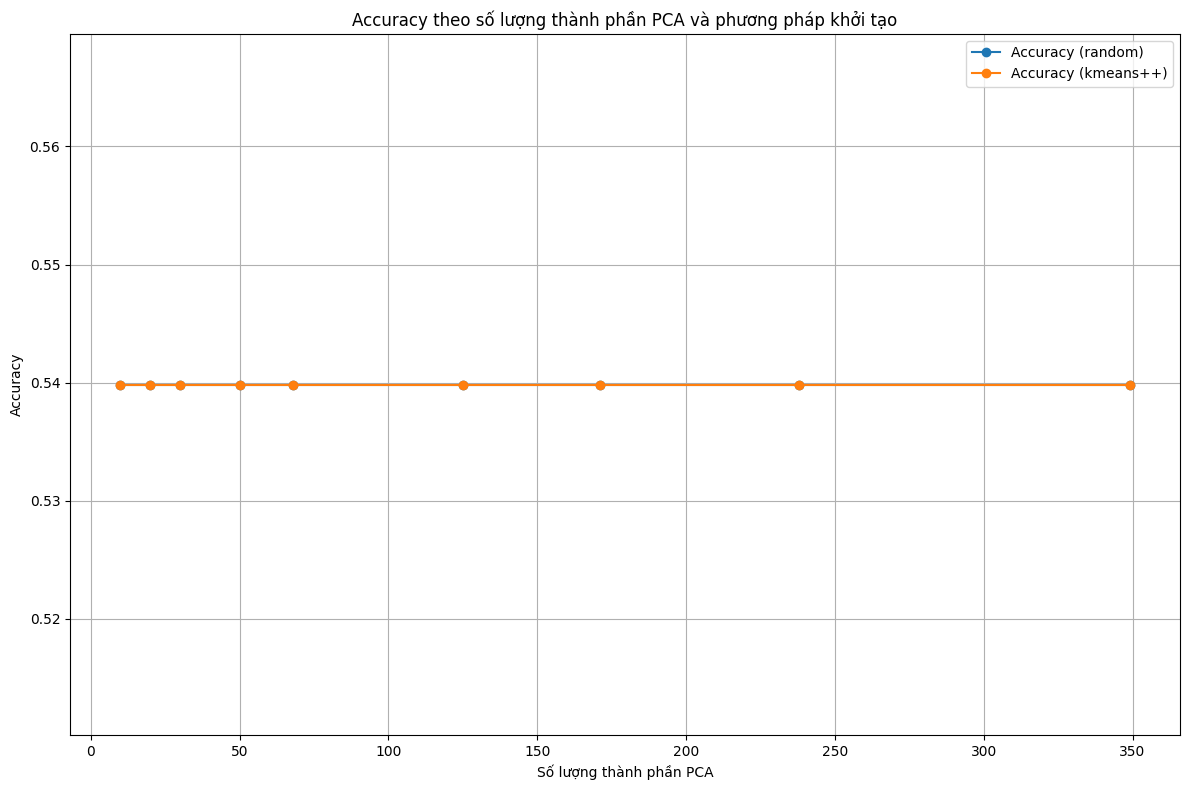

In [98]:
# Chọn các giá trị n_components để thử nghiệm
n_components_to_test = n_components_list.copy()

# Thêm một số giá trị nhỏ hơn để thử nghiệm
n_components_to_test.extend([10, 20, 30, 50])
n_components_to_test = sorted(list(set(n_components_to_test)))  # Loại bỏ trùng lặp

# Thử nghiệm các phương pháp khởi tạo khác nhau
init_methods = ['random', 'kmeans++']

# Lưu kết quả
results = []

# Thử nghiệm các tham số khác nhau
for n_comp in n_components_to_test:
    # Tạo PCA với số lượng thành phần
    pca = MyPCA(n_components=n_comp)
    X_reduced = pca.fit_transform(X_abide_std)
    
    for init in init_methods:
        # Thực hiện kmeans
        labels, centers, inertia = kmeans(
            X_reduced, k=2, max_iters=300, tol=1e-8, n_init=30, init_method=init)
        
        # Đánh giá kết quả
        # Sử dụng silhouette score để đánh giá độ tốt của phân cụm
        silhouette = silhouette_score(X_reduced, labels) if len(np.unique(labels)) > 1 else -1
        
        # So sánh với nhãn thực tế
        # Chú ý: Cần map clusters với nhãn thực tế
        # Vì clustering không biết nhãn nào là "Cancer" và nhãn nào là "Normal"
        # Thử cả hai cách gán nhãn và chọn cách tốt nhất
        
        # Cách 1: Cluster 0 -> Label 0, Cluster 1 -> Label 1
        accuracy1 = accuracy_score(y_numeric, labels)
        precision1 = precision_score(y_numeric, labels)
        recall1 = recall_score(y_numeric, labels)
        f1_1 = f1_score(y_numeric, labels)
        
        # Cách 2: Cluster 0 -> Label 1, Cluster 1 -> Label 0
        flipped_labels = 1 - labels
        accuracy2 = accuracy_score(y_numeric, flipped_labels)
        precision2 = precision_score(y_numeric, flipped_labels)
        recall2 = recall_score(y_numeric, flipped_labels)
        f1_2 = f1_score(y_numeric, flipped_labels)
        
        # Chọn cách gán nhãn tốt hơn (có accuracy cao hơn)
        if accuracy1 >= accuracy2:
            final_labels = labels
            accuracy = accuracy1
            precision = precision1
            recall = recall1
            f1 = f1_1
        else:
            final_labels = flipped_labels
            accuracy = accuracy2
            precision = precision2
            recall = recall2
            f1 = f1_2
        
        # Lưu kết quả
        result = {
            'n_components': n_comp,
            'init_method': init,
            'silhouette_score': silhouette,
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1_score': f1,
            'inertia': inertia
        }
        results.append(result)
        
        # In kết quả
        print(f"Components: {n_comp}, Init: {init}")
        print(f"  Silhouette: {silhouette:.3f}")
        print(f"  Accuracy: {accuracy:.3f}")
        print(f"  Precision: {precision:.3f}")
        print(f"  Recall: {recall:.3f}")
        print(f"  F1: {f1:.3f}")

# Chuyển kết quả thành DataFrame để dễ phân tích
results_df = pd.DataFrame(results)

# Tìm mô hình tốt nhất dựa trên accuracy và silhouette score
best_result = results_df.loc[results_df['accuracy'].idxmax()]
print("\nMô hình tốt nhất dựa trên accuracy:")
print(best_result)

# Vẽ biểu đồ so sánh các mô hình
plt.figure(figsize=(12, 8))

# Vẽ biểu đồ accuracy theo số lượng thành phần và phương pháp khởi tạo
for init in init_methods:
    df_init = results_df[results_df['init_method'] == init]
    plt.plot(df_init['n_components'], df_init['accuracy'], 'o-', label=f'Accuracy ({init})')

plt.grid(True)
plt.xlabel('Số lượng thành phần PCA')
plt.ylabel('Accuracy')
plt.title('Accuracy theo số lượng thành phần PCA và phương pháp khởi tạo')
plt.legend()
plt.tight_layout()


Kết quả cuối cùng với mô hình tốt nhất:
Số lượng thành phần PCA: 10
Phương pháp khởi tạo: random
Accuracy: 0.5398
Precision: 0.5013
Recall: 0.4082
F1 score: 0.4500
Silhouette score: 0.2866

Confusion matrix:
[[353 188]
 [274 189]]


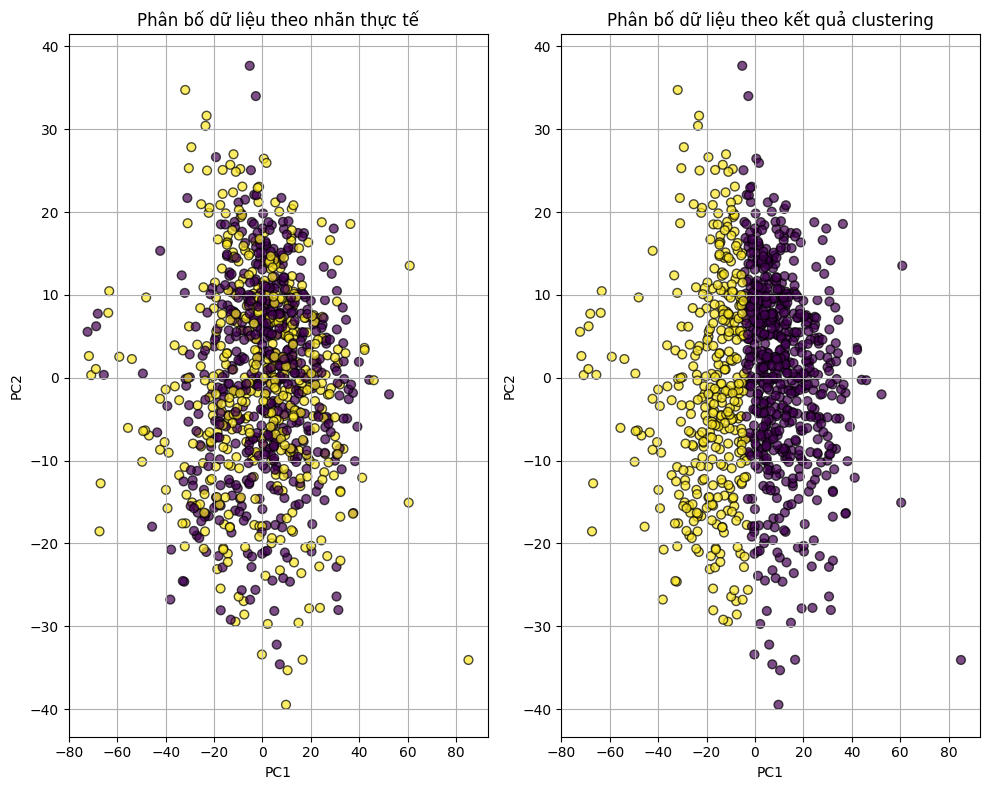

In [99]:
# Hiển thị kết quả của mô hình tốt nhất
best_n_components = int(best_result['n_components'])
best_init_method = best_result['init_method']

# Áp dụng PCA với số lượng thành phần tốt nhất
best_pca = MyPCA(n_components=best_n_components)
X_best_reduced = best_pca.fit_transform(X_abide_std)

# Thực hiện kmeans với tham số tốt nhất
best_labels, best_centers, _ = kmeans(
    X_best_reduced, k=2, max_iters=300, tol=1e-8, n_init=30, init_method=best_init_method)

# Kiểm tra và đảo nhãn nếu cần
if accuracy_score(y_numeric, best_labels) < accuracy_score(y_numeric, 1 - best_labels):
    best_labels = 1 - best_labels

# Tính toán confusion matrix
conf_matrix = confusion_matrix(y_numeric, best_labels)

# In kết quả cuối cùng
print("\nKết quả cuối cùng với mô hình tốt nhất:")
print(f"Số lượng thành phần PCA: {best_n_components}")
print(f"Phương pháp khởi tạo: {best_init_method}")
print(f"Accuracy: {accuracy_score(y_numeric, best_labels):.4f}")
print(f"Precision: {precision_score(y_numeric, best_labels):.4f}")
print(f"Recall: {recall_score(y_numeric, best_labels):.4f}")
print(f"F1 score: {f1_score(y_numeric, best_labels):.4f}")
print(f"Silhouette score: {silhouette_score(X_best_reduced, best_labels):.4f}")

print("\nConfusion matrix:")
print(conf_matrix)

# Nếu có 2 thành phần chính, có thể vẽ biểu đồ phân cụm
if best_n_components >= 2:
    plt.figure(figsize=(10, 8))
    
    # Nếu số lượng components > 2, chỉ vẽ 2 thành phần đầu tiên
    plot_X = X_best_reduced[:, :2]
    
    # Màu sắc theo nhóm thực tế (y)
    plt.subplot(1, 2, 1)
    plt.scatter(plot_X[:, 0], plot_X[:, 1], c=y_numeric, cmap='viridis', 
                alpha=0.7, edgecolors='k', s=40)
    plt.title('Phân bố dữ liệu theo nhãn thực tế')
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.grid(True)
    
    # Màu sắc theo nhóm dự đoán (clusters)
    plt.subplot(1, 2, 2)
    plt.scatter(plot_X[:, 0], plot_X[:, 1], c=best_labels, cmap='viridis', 
                alpha=0.7, edgecolors='k', s=40)
    plt.title('Phân bố dữ liệu theo kết quả clustering')
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()